<a href="https://colab.research.google.com/github/TheodorSergeev/optml_gan/blob/main/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Initialisation

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # packages to generate requirement.txt
    %pip install nbconvert
    %pip install pipreqs
    # for Frechet inception distance
    %pip install pytorch-fid

    %cd drive/My Drive/optml_gan2
    PATH = './'
else:
    PATH = './'

In [ ]:
from __future__ import print_function

import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data

import torchvision.utils as vutils
import torchvision.transforms.functional as tff

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
%matplotlib inline

In [ ]:
%load_ext autoreload
%autoreload 2

# Source code

In [ ]:
from src.data_handling import *
from src.utils import *
from src.model import *
from src.losses import *
from src.fid import *

loss_dict = {
    "kl": (loss_dis_kl, loss_gen_kl),
    "wass": (loss_dis_wasser, loss_gen_wasser),
    "hinge": (loss_dis_hinge, loss_gen_hinge)
}

# FID

from src.training import *
from src.visualisation import *
from src.serialisation import *

# https://keras.io/examples/generative/conditional_gan/
from src.architectures import *

from src.gridsearch import *

# Metrics

In [ ]:
# Root directory for dataset
dataroot = PATH + "data/"

# Dataset name
dataset_name = 'mnist' # 'cifar10' or 'mnist'

# Number of workers for dataloader
workers = 0

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 28 # 28 for mnist, 64 for others

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
create_repo_paths(PATH)
dataset, nc = get_dataset(dataset_name, image_size, dataroot)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load inception model
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx])
inception_model = inception_model.to(device)

# Init paths
create_repo_paths(PATH)
generated_data_path = PATH + 'generated_data/'
generated_data_path 

# Create a sample of the mnist dataset
batch_size_eval = 32 # 128
num_samples = 1000 # 1000
set_seeds(manualSeed=123)
which = torch.ones(len(dataset)).multinomial(num_samples, replacement=True)
dataset_subset = torch.utils.data.Subset(dataset, which)

real_dataloader = torch.utils.data.DataLoader(dataset_subset, batch_size=batch_size_eval,
                                         shuffle=False, num_workers=workers) # shuffle=False for reproducibility

list_subfolders_with_paths = sorted([f.path for f in os.scandir(generated_data_path) if f.is_dir()])

paths_adam = list_subfolders_with_paths[0:7]
paths_rmsprop = list_subfolders_with_paths[7:14]
paths_sgd = list_subfolders_with_paths[14:]

Random Seed:  123


In [ ]:
all_lr_scores_adam = get_fid_scores(ngpu, num_samples, real_dataloader, batch_size_eval, device, inception_model, nc, nz, workers,
                    list_paths = paths_adam , # paths_adam paths_sgd paths_rmsprop
                    which_iterations = [0,50,100,150,200,250,290], #[0,50,100,150,200,250,290] # [0,10,20,30,40,50,60,70,80,90,100,110,120, 130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290]
                    fix_extension = False,
                    calculate_frechet_bool = True
                    )
pickle_save(all_lr_scores_adam, generated_data_path + 'all_lr_scores_adam.pkl')
all_lr_scores_adam

In [ ]:
all_lr_scores_rmsprop = get_fid_scores(ngpu, num_samples, real_dataloader, batch_size_eval, device, inception_model, nc, nz, workers,
                    list_paths = paths_rmsprop , # paths_adam paths_sgd paths_rmsprop
                    which_iterations = [0,50,100,150,200,250,290], #[0,50,100,150,200,250,290] # [0,10,20,30,40,50,60,70,80,90,100,110,120, 130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290]
                    fix_extension = False,
                    calculate_frechet_bool = True
                    )

pickle_save(all_lr_scores_rmsprop, generated_data_path + 'all_lr_scores_rmsprop.pkl')
all_lr_scores_rmsprop

In [ ]:
all_lr_scores_sgd = get_fid_scores(ngpu, num_samples, real_dataloader, batch_size_eval, device, inception_model, nc, nz, workers,
                    list_paths = paths_sgd , # paths_adam paths_sgd paths_rmsprop
                    which_iterations = [0,50,100,150,200,250,290], #[0,50,100,150,200,250,290] # [0,10,20,30,40,50,60,70,80,90,100,110,120, 130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290]
                    fix_extension = False,
                    calculate_frechet_bool = True,
                    which_lrs = [1e-4,1e-5,1e-6,1e-7], # 1e-1 1e-2 1e-3 loss values are nans quickly
                    )
pickle_save(all_lr_scores_sgd, generated_data_path + 'all_lr_scores_sgd.pkl')
all_lr_scores_sgd

In [ ]:
all_lr_scores_sgd = pickle_load(generated_data_path + 'all_lr_scores_sgd.pkl')
all_lr_scores_rmsprop = pickle_load(generated_data_path + 'all_lr_scores_rmsprop.pkl')
all_lr_scores_adam = pickle_load(generated_data_path + 'all_lr_scores_adam.pkl')

In [ ]:
# for key,value in zip(all_lr_scores_sgd.keys(), all_lr_scores_sgd.values()):
#     print(key)
#     print('{:.2f}'.format(value[-1]))

# for key,value in zip(all_lr_scores_rmsprop.keys(), all_lr_scores_rmsprop.values()):
#     print(key)
#     print('{:.2f}'.format(value[-1]))


for key,value in zip(all_lr_scores_adam.keys(), all_lr_scores_adam.values()):
    print(key)
    print('{:.2f}'.format(value[-1]))

# print(all_lr_scores_sgd)
# print('______')
# print(all_lr_scores_rmsprop)
# print('______')
# print(all_lr_scores_adam)

1e-07
295.93
1e-06
230.87
1e-05
111.33
0.0001
44.93
0.001
90.54
0.01
365.71
0.1
281.94


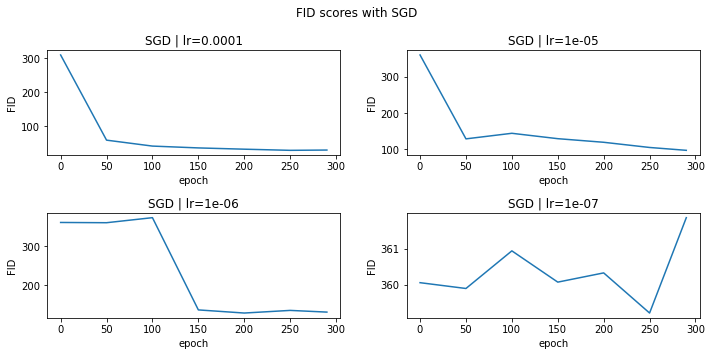

In [ ]:
fig, ax = plt.subplots(2,2,figsize = (10, 5))
for i, ax_,key, value in zip(range(4),ax.ravel(),all_lr_scores_sgd.keys(), all_lr_scores_sgd.values()):
    ax_.plot([0,50,100,150,200,250,290], value)
    ax_.set_title('SGD | lr='+ str(key))
    ax_.set_ylabel('FID')
    ax_.set_xlabel('epoch')

plt.suptitle('FID scores with SGD')
plt.tight_layout()
plt.show()

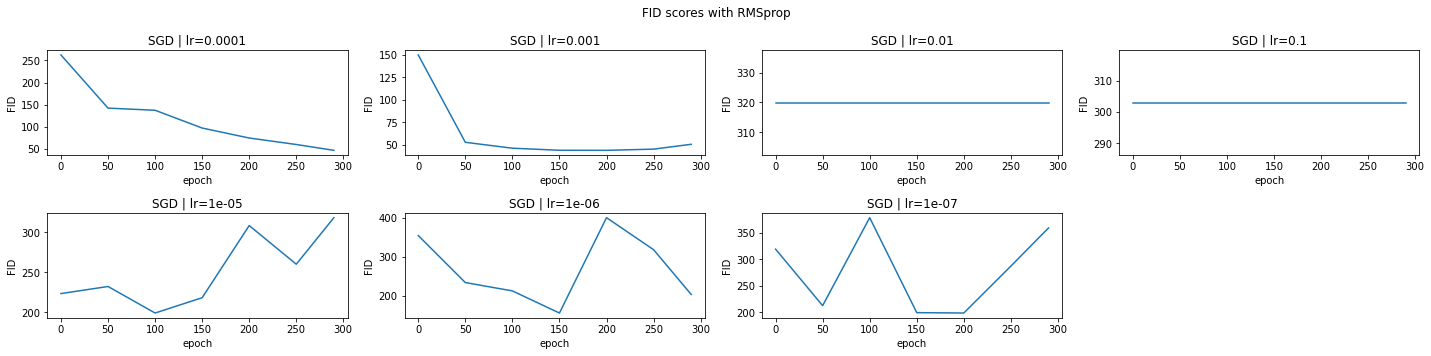

In [ ]:
fig, ax = plt.subplots(2,4,figsize = (20, 5))
for i, ax_,key, value in zip(range(7),ax.ravel(),all_lr_scores_rmsprop.keys(), all_lr_scores_rmsprop.values()):
    ax_.plot([0,50,100,150,200,250,290], value)
    ax_.set_title('SGD | lr='+ str(key))
    ax_.set_ylabel('FID')
    ax_.set_xlabel('epoch')

ax[1,3].set_axis_off()
plt.suptitle('FID scores with RMSprop')
plt.tight_layout()
plt.show()

In [ ]:
all_lr_scores_adam

{0.0001: [], 0.001: [], 0.01: [], 0.1: [], 1e-05: [], 1e-06: [], 1e-07: []}

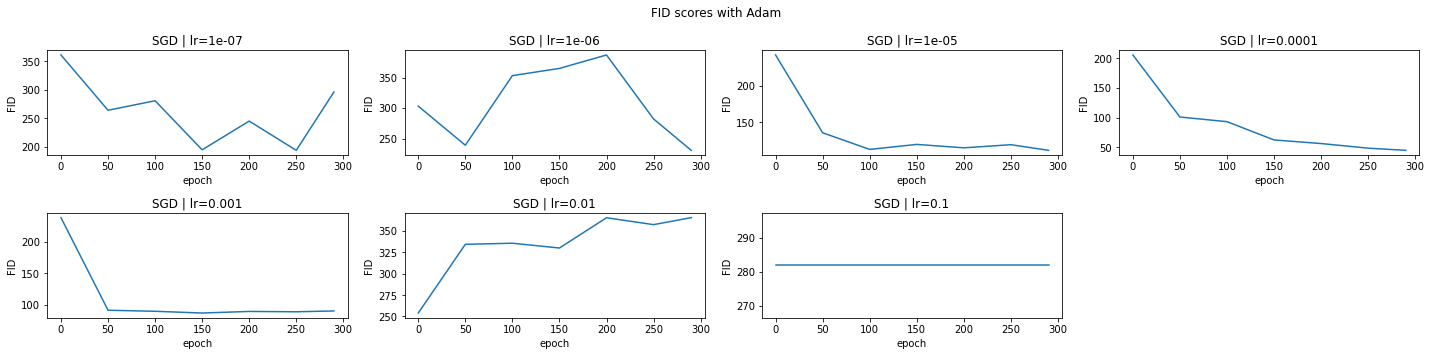

: 

In [ ]:
fig, ax = plt.subplots(2,4,figsize = (20, 5))
for i, ax_,key, value in zip(range(7),ax.ravel(),all_lr_scores_adam.keys(), all_lr_scores_adam.values()):
    ax_.plot([0,50,100,150,200,250,290], value)
    ax_.set_title('SGD | lr='+ str(key))
    ax_.set_ylabel('FID')
    ax_.set_xlabel('epoch')

ax[1,3].set_axis_off()

plt.suptitle('FID scores with Adam')
plt.tight_layout()
plt.show()

In [ ]:
from matplotlib import gridspec

In [ ]:
def show(imgs, save_path, save_fig, show_plot):
    if not isinstance(imgs, list):
        imgs = [imgs]
        
    fig = plt.figure(figsize=(8, 4))

    ax = [fig.add_subplot(1, len(imgs), i+1) for i in range(len(imgs))]

    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.set_aspect('equal')

    fig.subplots_adjust(wspace=0, hspace=0)

    for i, img in enumerate(imgs):
        img = img.detach()
        img = tff.to_pil_image(img)
        ax[i].imshow(np.asarray(img), cmap='gray')
        ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if save_fig:
        plt.savefig(save_path, format="png", dpi=400)
    if show_plot:
        plt.show()


In [ ]:
# plots
def get_loss_plots(generated_data_path, list_paths,
                   plot_losses=True,
                   save_gen_samples=True, show_plot=True, save_fig=False):

    for path in list_paths:
        folder = path[17:]

        param_list = folder.split('_')

        optimizer_name = param_list[0]
        loss_name = param_list[3][:-4]
        lr = param_list[4][3:]

        print(optimizer_name, lr)
        score_list = []

        stats_path = path + '/stat.pickle'
        stats = pickle_load(stats_path)
        # 8x8 images fake generatred images in one picture
        img_list = stats['img_list']
        G_losses = stats['G_losses']
        D_losses = stats['D_losses']
        save_path = PATH + 'img/real_vs_fake_'+folder+'.png'

        if plot_losses:
            plot_loss(G_losses, D_losses, save_path, title_fontsize=18, x_fontsize=15, y_fontsize=15, yticks_size=12,
                      xticks_size=12, save=True, show_plot=show_plot)

        if save_gen_samples:
            save_path = PATH + 'img/'+optimizer_name+lr+'.png'
            # 64 fake generatred images in a list
            img_list_nogrid = stats['img_list_nogrid']
            img_list_nogrid_2 = img_list_nogrid[-1]
            show([img.squeeze() for img in img_list_nogrid_2[:5]],
                 save_path, save_fig, show_plot)


rmsprop_mG0_mD0_wassLoss_lrd0.0001_lrg0.0001_b1b0.9_itd5_itg1_gpv10.0_
rmsprop 0.0001
./img/real_vs_fake_rmsprop_mG0_mD0_wassLoss_lrd0.0001_lrg0.0001_b1b0.9_itd5_itg1_gpv10.0_.png
rmsprop_mG0_mD0_wassLoss_lrd0.001_lrg0.001_b1b0.9_itd5_itg1_gpv10.0_
rmsprop 0.001
./img/real_vs_fake_rmsprop_mG0_mD0_wassLoss_lrd0.001_lrg0.001_b1b0.9_itd5_itg1_gpv10.0_.png
rmsprop_mG0_mD0_wassLoss_lrd0.01_lrg0.01_b1b0.9_itd5_itg1_gpv10.0_
rmsprop 0.01
./img/real_vs_fake_rmsprop_mG0_mD0_wassLoss_lrd0.01_lrg0.01_b1b0.9_itd5_itg1_gpv10.0_.png
rmsprop_mG0_mD0_wassLoss_lrd0.1_lrg0.1_b1b0.9_itd5_itg1_gpv10.0_
rmsprop 0.1
./img/real_vs_fake_rmsprop_mG0_mD0_wassLoss_lrd0.1_lrg0.1_b1b0.9_itd5_itg1_gpv10.0_.png
rmsprop_mG0_mD0_wassLoss_lrd1e-05_lrg1e-05_b1b0.9_itd5_itg1_gpv10.0_
rmsprop 1e-05
./img/real_vs_fake_rmsprop_mG0_mD0_wassLoss_lrd1e-05_lrg1e-05_b1b0.9_itd5_itg1_gpv10.0_.png
rmsprop_mG0_mD0_wassLoss_lrd1e-06_lrg1e-06_b1b0.9_itd5_itg1_gpv10.0_
rmsprop 1e-06
./img/real_vs_fake_rmsprop_mG0_mD0_wassLoss_lrd1e-06

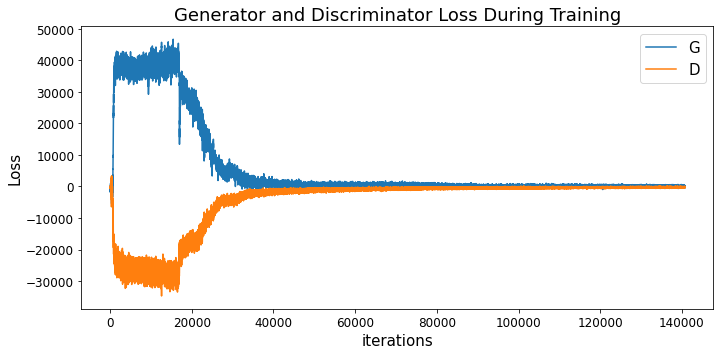

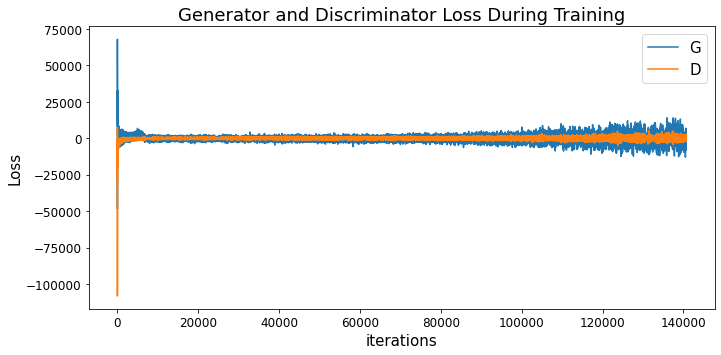

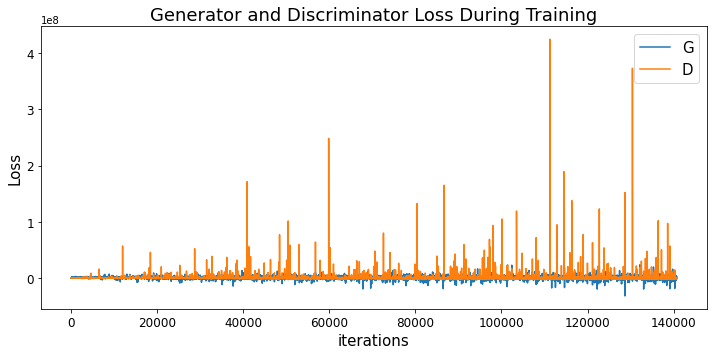

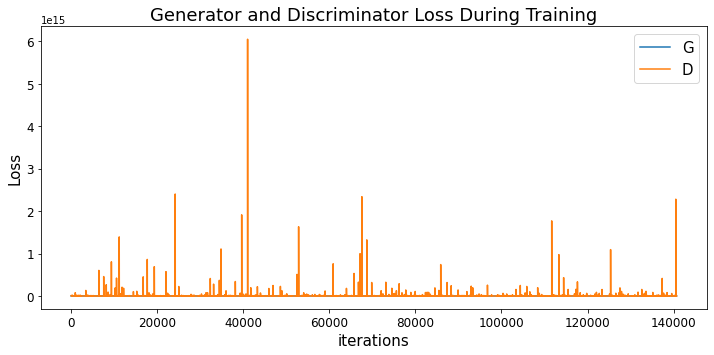

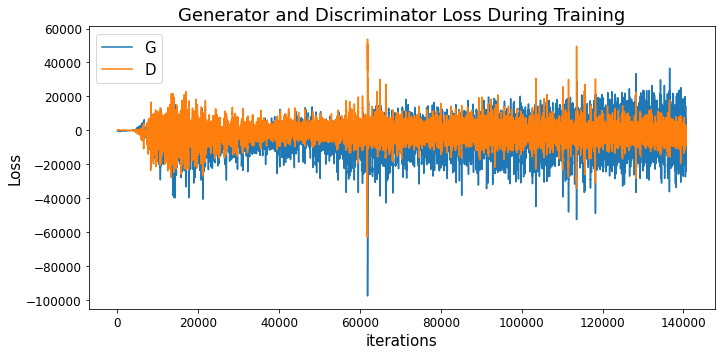

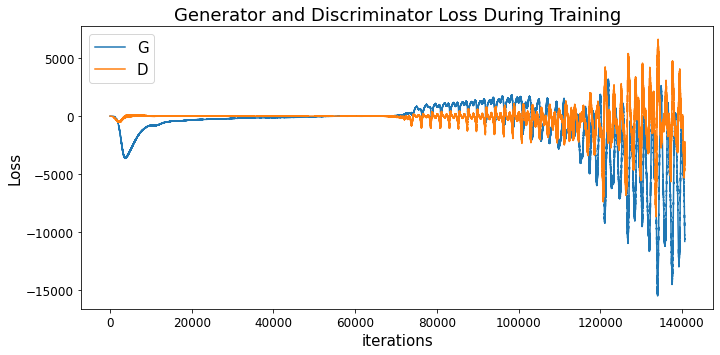

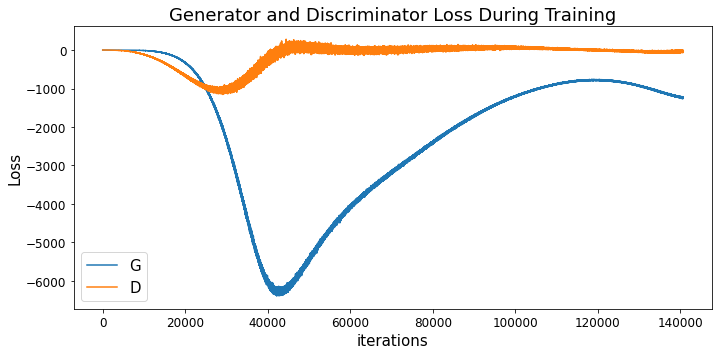

In [ ]:
get_loss_plots(generated_data_path, list_paths = paths_rmsprop,
    plot_losses = True,
    save_gen_samples = False, show_plot=False)

adam_mG0_mD0_wassLoss_lrd0.0001_lrg0.0001_b1b0.9_itd5_itg1_gpv10.0_
adam 0.0001
./img/real_vs_fake_adam_mG0_mD0_wassLoss_lrd0.0001_lrg0.0001_b1b0.9_itd5_itg1_gpv10.0_.png
adam_mG0_mD0_wassLoss_lrd0.001_lrg0.001_b1b0.9_itd5_itg1_gpv10.0_
adam 0.001
./img/real_vs_fake_adam_mG0_mD0_wassLoss_lrd0.001_lrg0.001_b1b0.9_itd5_itg1_gpv10.0_.png
adam_mG0_mD0_wassLoss_lrd0.01_lrg0.01_b1b0.9_itd5_itg1_gpv10.0_
adam 0.01
./img/real_vs_fake_adam_mG0_mD0_wassLoss_lrd0.01_lrg0.01_b1b0.9_itd5_itg1_gpv10.0_.png
adam_mG0_mD0_wassLoss_lrd0.1_lrg0.1_b1b0.9_itd5_itg1_gpv10.0_
adam 0.1
./img/real_vs_fake_adam_mG0_mD0_wassLoss_lrd0.1_lrg0.1_b1b0.9_itd5_itg1_gpv10.0_.png
adam_mG0_mD0_wassLoss_lrd1e-05_lrg1e-05_b1b0.9_itd5_itg1_gpv10.0_
adam 1e-05
./img/real_vs_fake_adam_mG0_mD0_wassLoss_lrd1e-05_lrg1e-05_b1b0.9_itd5_itg1_gpv10.0_.png
adam_mG0_mD0_wassLoss_lrd1e-06_lrg1e-06_b1b0.9_itd5_itg1_gpv10.0_
adam 1e-06
./img/real_vs_fake_adam_mG0_mD0_wassLoss_lrd1e-06_lrg1e-06_b1b0.9_itd5_itg1_gpv10.0_.png
adam_mG0_mD0_w

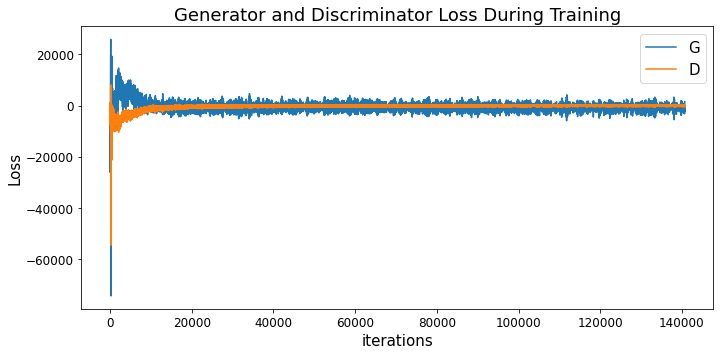

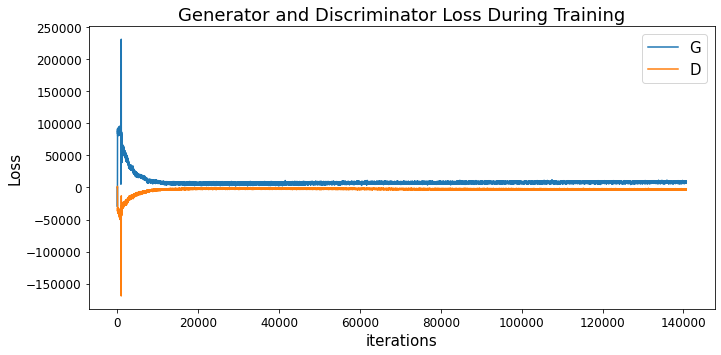

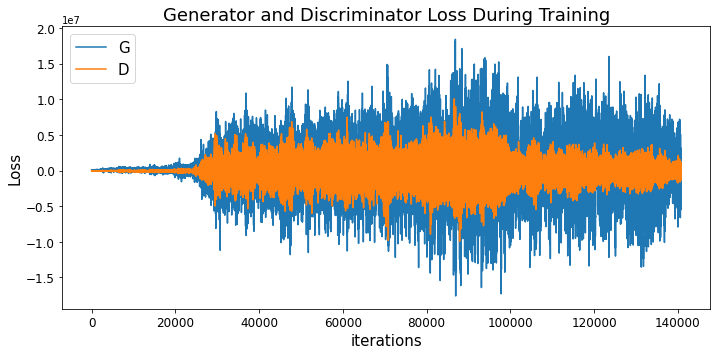

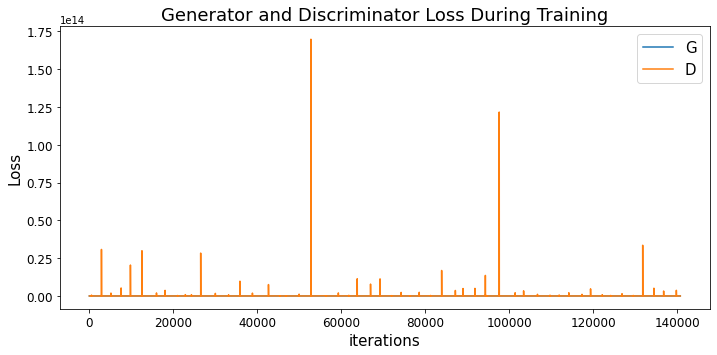

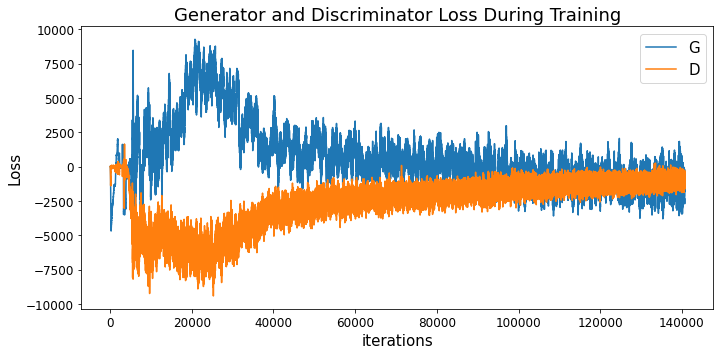

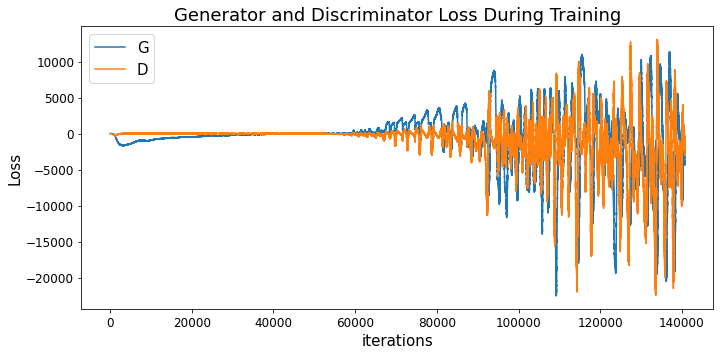

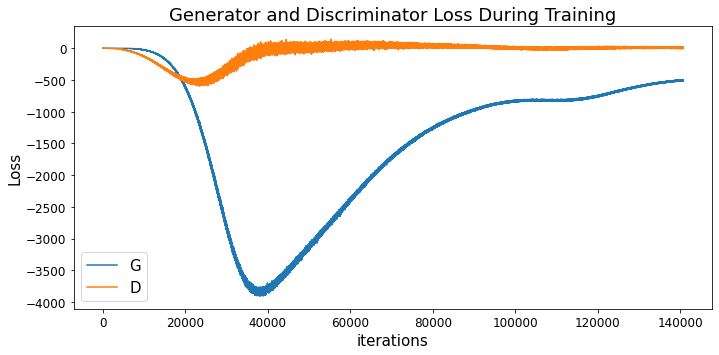

In [ ]:
get_loss_plots(generated_data_path,list_paths = paths_adam,
    plot_losses = True,
    save_gen_samples = False,show_plot=False)

sgd_mG0_mD0_wassLoss_lrd0.0001_lrg0.0001_b1b0.9_itd5_itg1_gpv10.0_
sgd 0.0001
./img/real_vs_fake_sgd_mG0_mD0_wassLoss_lrd0.0001_lrg0.0001_b1b0.9_itd5_itg1_gpv10.0_.png
sgd_mG0_mD0_wassLoss_lrd0.001_lrg0.001_b1b0.9_itd5_itg1_gpv10.0_
sgd 0.001
./img/real_vs_fake_sgd_mG0_mD0_wassLoss_lrd0.001_lrg0.001_b1b0.9_itd5_itg1_gpv10.0_.png
sgd_mG0_mD0_wassLoss_lrd0.01_lrg0.01_b1b0.9_itd5_itg1_gpv10.0_
sgd 0.01
./img/real_vs_fake_sgd_mG0_mD0_wassLoss_lrd0.01_lrg0.01_b1b0.9_itd5_itg1_gpv10.0_.png
sgd_mG0_mD0_wassLoss_lrd0.1_lrg0.1_b1b0.9_itd5_itg1_gpv10.0_
sgd 0.1
./img/real_vs_fake_sgd_mG0_mD0_wassLoss_lrd0.1_lrg0.1_b1b0.9_itd5_itg1_gpv10.0_.png
sgd_mG0_mD0_wassLoss_lrd1e-05_lrg1e-05_b1b0.9_itd5_itg1_gpv10.0_
sgd 1e-05
./img/real_vs_fake_sgd_mG0_mD0_wassLoss_lrd1e-05_lrg1e-05_b1b0.9_itd5_itg1_gpv10.0_.png
sgd_mG0_mD0_wassLoss_lrd1e-06_lrg1e-06_b1b0.9_itd5_itg1_gpv10.0_
sgd 1e-06
./img/real_vs_fake_sgd_mG0_mD0_wassLoss_lrd1e-06_lrg1e-06_b1b0.9_itd5_itg1_gpv10.0_.png
sgd_mG0_mD0_wassLoss_lrd1e-07_lr

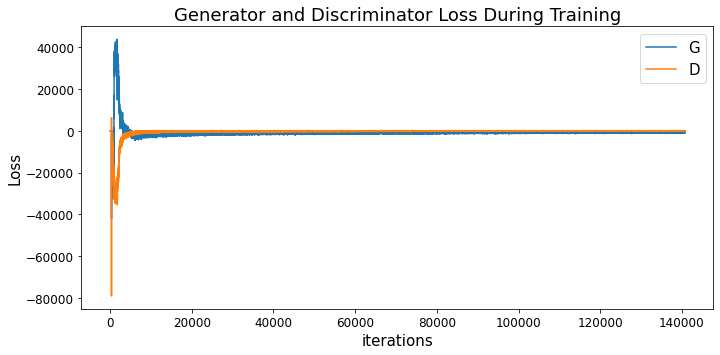

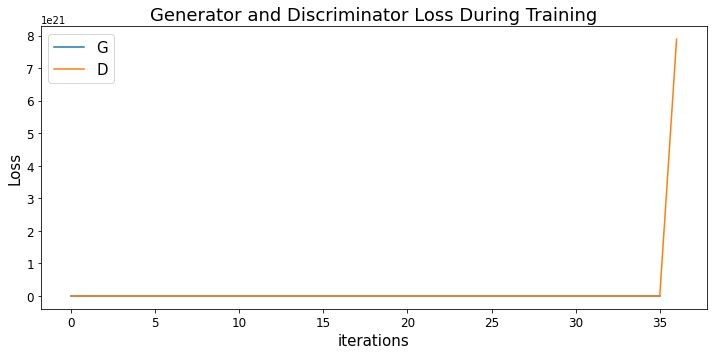

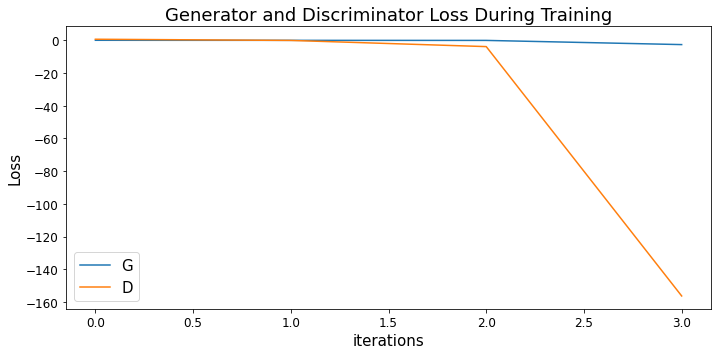

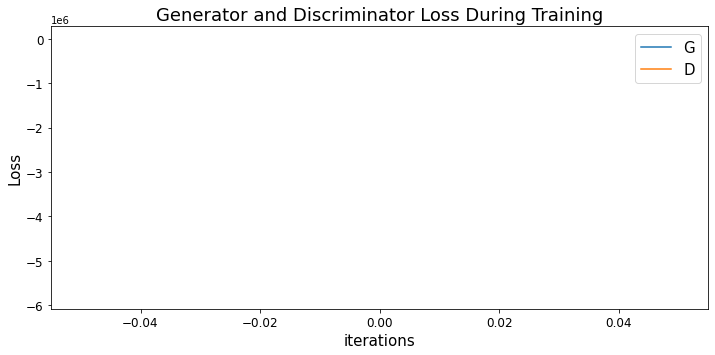

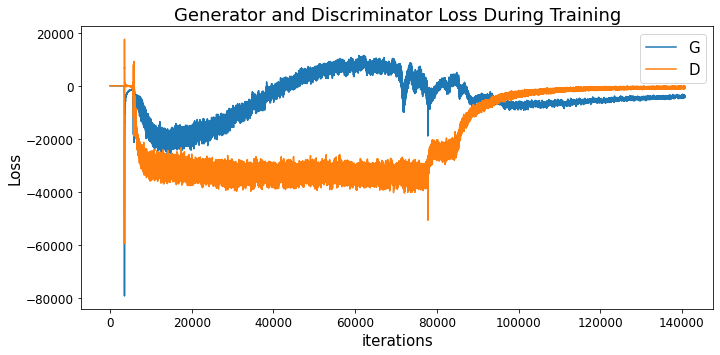

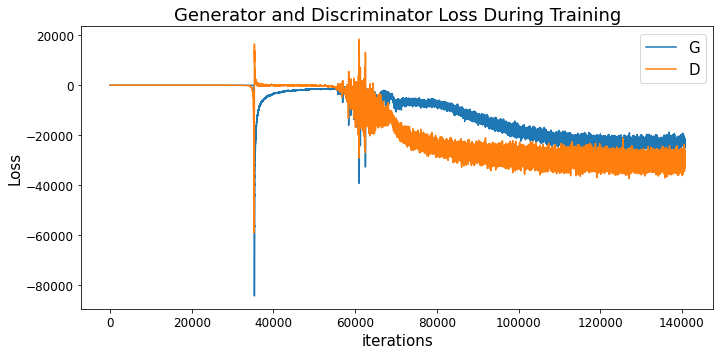

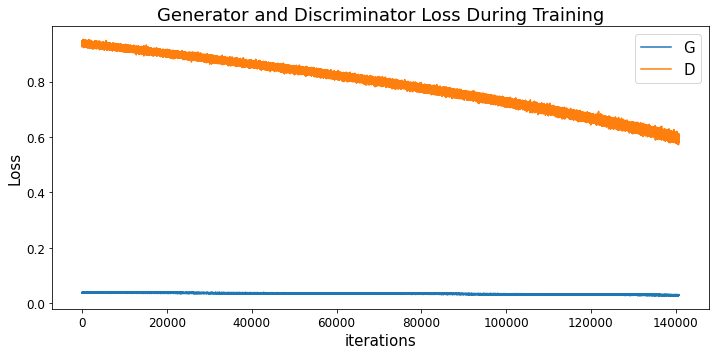

In [ ]:
get_loss_plots(generated_data_path,list_paths = paths_sgd,
    plot_losses = True,
    save_gen_samples = False,show_plot=False)

rmsprop 0.0001


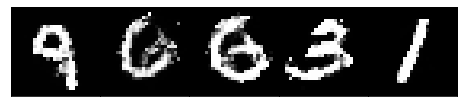

rmsprop 0.001


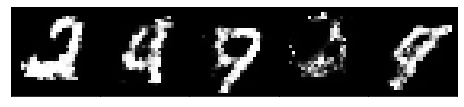

rmsprop 0.01


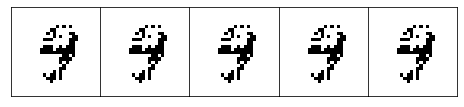

rmsprop 0.1


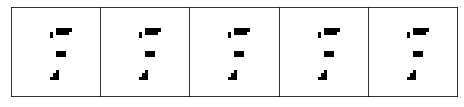

rmsprop 1e-05


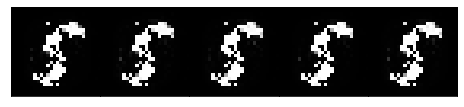

rmsprop 1e-06


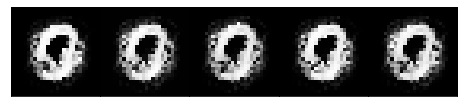

rmsprop 1e-07


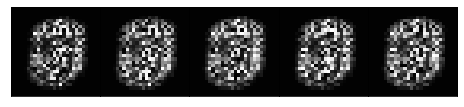

In [ ]:
get_loss_plots(generated_data_path, list_paths = paths_rmsprop,
    plot_losses = False, save_gen_samples = True,show_plot=True, 
    save_fig=True) # TO DO fix these ugly plots

adam 0.0001


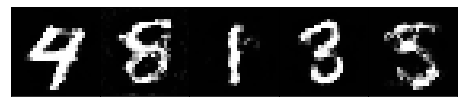

adam 0.001


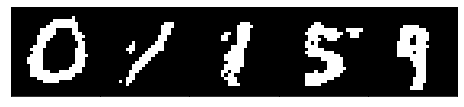

adam 0.01


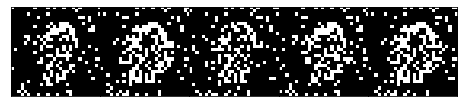

adam 0.1


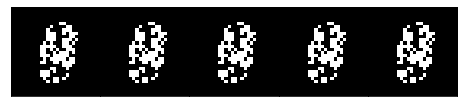

adam 1e-05


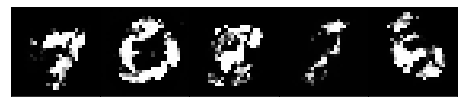

adam 1e-06


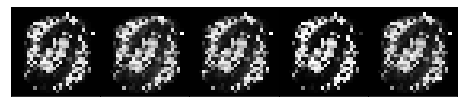

adam 1e-07


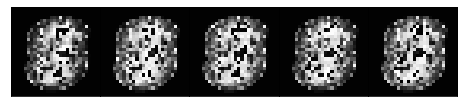

In [ ]:
get_loss_plots(generated_data_path, list_paths = paths_adam,
    plot_losses = False, save_gen_samples = True,show_plot=True, 
    save_fig=True) # TO DO fix these ugly plots

sgd 0.0001


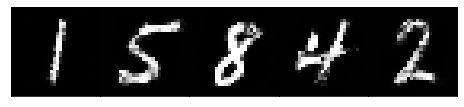

sgd 0.001


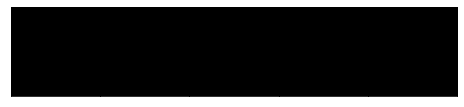

sgd 0.01


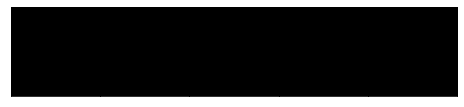

sgd 0.1


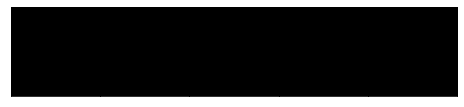

sgd 1e-05


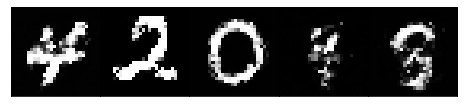

sgd 1e-06


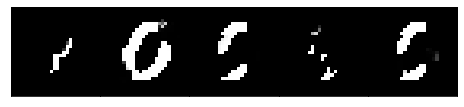

sgd 1e-07


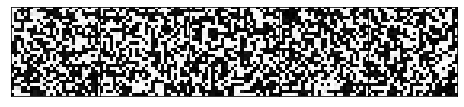

In [ ]:
get_loss_plots(generated_data_path, list_paths = paths_sgd,
    plot_losses = False, save_gen_samples = True,show_plot=True, 
    save_fig=True) # TO DO fix these ugly plots